# RNN - introduction

In this tutorial we learn how the reccurent neural networks work and are used in text classification.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import argparse
import datetime
import os
import re

import numpy as np
import tensorflow as tf

from morpho_dataset import MorphoDataset

from keras.callbacks import EarlyStopping

import shutil

# Morpho dataset
- from Deep Learning course by Milan Straka
- https://github.com/ufal/npfl114/tree/past-1920/labs/07

## Define the network

In [2]:
class Network:
    def __init__(self, pdt, args):
        # Define a suitable model.

        num_tags = len(pdt.train.data[pdt.train.TAGS].words)
        num_words = len(pdt.train.data[pdt.train.FORMS].words)
        num_chars = len(pdt.train.data[pdt.train.FORMS].alphabet)
       
        
        # Implement a one-layer RNN network. The input
        # `word_ids` consists of a batch of sentences, each
        # a sequence of word indices. Padded words have index 0.

        # Embed input words with dimensionality `args.we_dim`,
        # using `mask_zero=True`.

        word_ids = tf.keras.Input(shape=(None,), dtype='int32')
        we = tf.keras.layers.Embedding(input_dim=num_words, output_dim=args.we_dim, mask_zero=True)(word_ids)

        # The RNN character-level embeddings utilize the input `charseqs`
        # containing a sequence of character indices for every input word.
        # Again, padded characters have index 0.

        charseqs = tf.keras.Input(shape=(None, None, ), dtype='int32')

        # Because cuDNN implementation of RNN does not allow empty sequences,
        # we need to consider only charseqs for valid words.
        valid_words = tf.where(word_ids != 0)
        cle = tf.gather_nd(charseqs, valid_words)

        # Embed the characters in `cle` using embeddings of size
        # `args.cle_dim`, masking zero indices. Then, pass the embedded characters
        # through a bidirectional GRU with dimension `args.cle_dim`, concatenating
        # results from forward and backward pass. Store the computed embeddings
        # in `cle` variable.

        cle = tf.keras.layers.Embedding(input_dim=num_chars, output_dim=args.cle_dim, mask_zero=True)(cle)

        forward_layer = tf.keras.layers.GRU(args.cle_dim)
        backward_layer = tf.keras.layers.GRU(args.cle_dim, go_backwards=True)

        cle = tf.keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer)(cle)

        # Now we copy cle-s back to the original shape.
        cle = tf.scatter_nd(valid_words, cle, [tf.shape(charseqs)[0], tf.shape(charseqs)[1], cle.shape[-1]])

        # Concatenate the WE and CLE embeddings (in this order).
        # Use a `tf.keras.layers.Concatenate()` layer, which preserves masks
        # (contrary to raw methods like tf.concat).

        concat = tf.keras.layers.Concatenate()([we, cle])

        # Create specified `args.rnn_cell` RNN cell (LSTM, GRU) with
        # dimension `args.rnn_cell_dim` and apply it in a bidirectional way on
        # the embedded words, summing the outputs of forward and backward RNNs.

        if args.rnn_cell == 'LSTM':
            forward_layer = tf.keras.layers.LSTM(args.rnn_cell_dim, return_sequences=True)
            backward_layer = tf.keras.layers.LSTM(args.rnn_cell_dim, return_sequences=True, go_backwards=True)
        else:
            forward_layer = tf.keras.layers.GRU(args.rnn_cell_dim, return_sequences=True)
            backward_layer = tf.keras.layers.GRU(args.rnn_cell_dim, return_sequences=True, go_backwards=True)
        rnn_layer = tf.keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer, merge_mode='sum')(concat)


        # Add a softmax classification layer into `num_tags` classes, storing
        # the outputs in `predictions`.

        predictions = tf.keras.layers.Dense(num_tags, activation=tf.nn.softmax)(rnn_layer)

        self.model = tf.keras.Model(inputs=[word_ids, charseqs], outputs=predictions)
        self.model.compile(optimizer=tf.optimizers.Adam(),
                           loss=tf.losses.SparseCategoricalCrossentropy(),
                           metrics=[tf.metrics.SparseCategoricalAccuracy(name="accuracy")])

        self._writer = tf.summary.create_file_writer(args.logdir, flush_millis=10 * 1000)



    def train_epoch(self, dataset, args):
        for batch in dataset.batches(args.batch_size):
            metrics = self.model.train_on_batch(
                [batch[dataset.FORMS].word_ids, batch[dataset.FORMS].charseqs],
                batch[dataset.TAGS].word_ids,
                reset_metrics=True)

            # Generate the summaries each 100 steps
            if self.model.optimizer.iterations % 100 == 0:
                tf.summary.experimental.set_step(self.model.optimizer.iterations)
                with self._writer.as_default():
                    for name, value in zip(self.model.metrics_names, metrics):
                        tf.summary.scalar("train/{}".format(name), value)



    def evaluate(self, dataset, dataset_name, args):
        # We assume that model metric are already resetted at this point.
        for batch in dataset.batches(args.batch_size):
            # Evaluate the given batch with `test_on_batch`, using the
            # same inputs as in training, but pass `reset_metrics=False` to
            # aggregate the metrics. Store the metrics of the last batch as `metrics`.
            metrics = self.model.test_on_batch(
                [batch[dataset.FORMS].word_ids, batch[dataset.FORMS].charseqs],
                batch[dataset.TAGS].word_ids,
                reset_metrics=False)
        self.model.reset_metrics()

        metrics = dict(zip(self.model.metrics_names, metrics))
        with self._writer.as_default():
            tf.summary.experimental.set_step(self.model.optimizer.iterations)
            for name, value in metrics.items():
                tf.summary.scalar("{}/{}".format(dataset_name, name), value)

        return metrics

## Define hyperparameters

In [3]:
parser = argparse.ArgumentParser()
# Define reasonable defaults and optionally more parameters
parser.add_argument("--batch_size", default=128, type=int, help="Batch size.")
parser.add_argument("--epochs", default=100, type=int, help="Number of epochs.")
parser.add_argument("--we_dim", default=2, type=int, help="Word embedding dimension.")
parser.add_argument("--rnn_cell", default="LSTM", type=str, help="RNN cell type.")
parser.add_argument("--rnn_cell_dim", default=16, type=int, help="RNN cell dimension.")
parser.add_argument("--cle_dim", default=16, type=int, help="CLE embedding dimension.")
parser.add_argument("--seed", default=42, type=int, help="Random seed.")
parser.add_argument("--threads", default=8, type=int, help="Maximum number of threads to use.")
parser.add_argument("--verbose", default=False, action="store_true", help="Verbose TF logging.")
args = parser.parse_args([] if "__file__" not in globals() else None)

In [4]:
# fix seed and set threads
np.random.seed(args.seed)
tf.random.set_seed(args.seed)
tf.config.threading.set_inter_op_parallelism_threads(args.threads)
tf.config.threading.set_intra_op_parallelism_threads(args.threads)

In [5]:
# Report only errors by default
if not args.verbose:
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [6]:
# load the dataset
morpho = MorphoDataset("czech_pdt")

In [7]:
# Create logdir name
args.logdir = os.path.join("logs", "{}-{}-{}".format(
    os.path.basename(globals().get("__file__", "notebook")),
    datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S"),
    ",".join(("{}={}".format(re.sub("(.)[^_]*_?", r"\1", key), value) for key, value in sorted(vars(args).items())))
))

## Check the data

In [8]:
(morpho.train.data[0].words)

['<pad>',
 '<unk>',
 'Třikrát',
 'rychlejší',
 'než',
 'slovo',
 'Faxu',
 'škodí',
 'především',
 'přetížené',
 'telefonní',
 'linky',
 '*',
 'Pomocí',
 'může',
 'být',
 'systém',
 'ECM',
 'Šetřete',
 'peníze',
 ',',
 'netelefonujte',
 'faxujte',
 '!',
 'Je',
 'tento',
 'reklamní',
 'slogan',
 'pravdivý',
 '?',
 'Hlasité',
 'přečtení',
 'dobře',
 'čitelného',
 'textu',
 'na',
 'stránce',
 'A',
 '4',
 'při',
 'řádkování',
 '1.5',
 'trvá',
 'zhruba',
 '3',
 'minuty',
 '.',
 'Podle',
 'prospektů',
 'se',
 'faxem',
 'přenese',
 'normalizovaný',
 'obsah',
 'jedné',
 'stránky',
 'za',
 '10',
 'až',
 '30',
 'sekund',
 'Ve',
 'skutečnosti',
 'to',
 'sice',
 'minutu',
 'protože',
 'doba',
 'přenosu',
 'více',
 'závisí',
 'stavu',
 'rychlosti',
 'přístroje',
 'ale',
 'i',
 'tak',
 'je',
 'přenos',
 'informace',
 'třikrát',
 'řeč',
 'Navíc',
 'současně',
 'vznikne',
 'písemný',
 'doklad',
 'lze',
 'přenášet',
 'obrázky',
 'grafy',
 'fotografie',
 'rukou',
 'psané',
 'texty',
 'apod',
 'Přenosová'

In [9]:
len(morpho.train.data[0].words)

147458

In [10]:
(morpho.train.data[0].alphabet)

['<pad>',
 '<unk>',
 '<bow>',
 '<eow>',
 'T',
 'ř',
 'i',
 'k',
 'r',
 'á',
 't',
 'y',
 'c',
 'h',
 'l',
 'e',
 'j',
 'š',
 'í',
 'n',
 'ž',
 's',
 'o',
 'v',
 'F',
 'a',
 'x',
 'u',
 'd',
 'p',
 'm',
 'é',
 'f',
 '*',
 'P',
 'ů',
 'b',
 'ý',
 'E',
 'C',
 'M',
 'Š',
 'z',
 ',',
 '!',
 'J',
 'g',
 '?',
 'H',
 'č',
 'A',
 '4',
 '1',
 '.',
 '5',
 '3',
 '0',
 'V',
 'N',
 'ě',
 'ú',
 'I',
 'S',
 '-',
 'U',
 'O',
 'Z',
 '9',
 '%',
 'B',
 'L',
 'K',
 '6',
 ':',
 'ň',
 'Ř',
 'R',
 '8',
 '7',
 'ť',
 'D',
 'Č',
 '(',
 ')',
 '2',
 '"',
 'G',
 'Y',
 'Á',
 'Ě',
 'Í',
 '+',
 '/',
 'ó',
 'X',
 'Ý',
 'Ú',
 'Ž',
 'É',
 'ď',
 'W',
 'ü',
 'Ů',
 '|',
 ';',
 'w',
 'Q',
 'q',
 '&',
 'ö',
 'ä',
 'Ľ',
 'Ó',
 '=',
 'è',
 'Ť',
 '^',
 '$',
 '[',
 ']',
 'Ň',
 '§',
 "'",
 'ć',
 'Ö',
 '>',
 '°',
 'ñ',
 '`',
 'ľ',
 'Ü',
 'Ď',
 '_',
 'ŕ',
 '\\',
 'à',
 'ˇ',
 '}',
 '#',
 '@',
 'ô',
 'Ĺ',
 'ë',
 '®',
 'Ä',
 'ç',
 'ł',
 'ę']

In [11]:
len(morpho.train.data[0].alphabet)

148

In [12]:
morpho.train.data[0].word_ids

[array([2, 3, 4, 5]),
 array([ 6,  7,  8,  9, 10, 11, 12]),
 array([13, 14, 15, 16, 17]),
 array([18, 19, 20, 21, 20, 22, 23]),
 array([24, 25, 26, 27, 28, 29]),
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 20, 39, 40, 41, 20, 42, 43, 44,
        45, 46]),
 array([47, 48, 49, 50, 51, 52, 53, 54, 55, 37, 38, 56, 57, 58, 59, 60, 46]),
 array([61, 62, 63, 64, 42, 43, 65, 20, 66, 67, 68, 69, 70, 35, 71, 10, 11,
         4, 35, 72, 73, 20, 74, 75, 76, 77, 78, 79, 50, 43, 80,  3,  4, 81,
        46]),
 array([82, 83, 84, 85, 86, 20, 87, 88, 89, 20, 90, 20, 91, 20, 92, 93, 94,
        95, 46]),
 array([ 96,  97,  73,  98,  10,  99,  20,  76,  49, 100, 101, 102,  20,
        103, 104, 105, 106,  20,  77,  64, 107, 108,  98, 109, 110, 111,
         20,  74, 112, 113, 114, 115, 116, 117,  46]),
 array([118, 119, 120,  77, 121, 122,  49, 123,  39, 124, 102,  98, 125,
        126,  20,  77, 127, 128, 129, 130,  20, 131,  77, 127,  25, 108,
         20, 132, 133, 134,  20, 135, 136, 137, 138, 139,  

In [13]:
len(morpho.train.data[0].word_ids)

90828

In [14]:
# targets
morpho.train.data[morpho.train.TAGS].word_strings

[['Cv-------------', 'AAFS1----2A----', 'J,-------------', 'NNNS1-----A----'],
 ['NNIS3-----A----',
  'VB-P---3P-AA---',
  'Db-------------',
  'AAFP1----1A----',
  'AAFP1----1A----',
  'NNFP1-----A----',
  'Z:-------------'],
 ['NNFS7-----A----',
  'VB-S---3P-AA---',
  'Vf--------A----',
  'NNIS1-----A----',
  'NNIXX-----A---8'],
 ['Vi-P---2--A----',
  'NNIP4-----A----',
  'Z:-------------',
  'Vi-P---2--N----',
  'Z:-------------',
  'Vi-P---2--A----',
  'Z:-------------'],
 ['VB-S---3P-AA---',
  'PDYS1----------',
  'AAIS1----1A----',
  'NNIS1-----A----',
  'AAIS1----1A----',
  'Z:-------------'],
 ['AANS1----1A----',
  'NNNS1-----A----',
  'Dg-------1A----',
  'AAIS2----1A----',
  'NNIS2-----A----',
  'RR--6----------',
  'NNFS6-----A----',
  'NNFXX-----A---8',
  'C=-------------',
  'Z:-------------',
  'RR--6----------',
  'NNNS6-----A----',
  'C=-------------',
  'Z:-------------',
  'VB-S---3P-AA---',
  'Db-------------',
  'C=-------------',
  'NNFP4-----A----',
  'Z:---------

In [15]:
morpho.train.data[morpho.train.TAGS].word_ids

[array([2, 3, 4, 5]),
 array([ 6,  7,  8,  9,  9, 10, 11]),
 array([12, 13, 14, 15, 16]),
 array([17, 18, 11, 19, 11, 17, 11]),
 array([13, 20, 21, 15, 21, 11]),
 array([22,  5, 23, 24, 25, 26, 27, 28, 29, 11, 26, 30, 29, 11, 13,  8, 29,
        31, 11]),
 array([32, 33, 34, 35, 13, 21, 15, 36, 37, 28, 29, 38, 29, 39, 29, 40, 11]),
 array([41, 27, 42,  8, 13,  8, 43, 11,  4, 44, 25, 45, 13, 26, 46, 47, 37,
         4, 26, 27, 25, 11, 39, 39,  8, 13, 15, 37, 35,  8,  2, 48,  4, 44,
        11]),
 array([ 8, 23, 13, 21, 15, 11, 13, 14, 18, 11, 18, 11, 31, 11, 12, 49, 18,
        50, 11]),
 array([51, 44, 25, 38, 52, 53, 11,  8, 34, 23, 13,  5, 11, 26, 54,  8, 55,
        11, 13,  8, 21, 15, 38, 53, 56, 40, 11, 39, 13, 32, 57, 58, 59, 60,
        11]),
 array([ 4, 35, 25, 13, 61, 14, 34, 62, 26, 46, 58, 38, 63, 43, 11, 13, 22,
         8, 45, 14, 11,  8, 13, 22, 64, 60, 11, 59, 26, 65, 11, 14, 66,  4,
        59, 60, 11]),
 array([ 4, 67, 68, 26, 69, 27, 23, 70, 11, 71, 51, 51, 44, 72, 59

In [16]:
morpho.train.data[morpho.train.LEMMAS].word_strings

[['třikrát', 'rychlý', 'než-2', 'slovo'],
 ['fax', 'škodit', 'především', 'přetížený', 'telefonní', 'linka', '*'],
 ['pomoc', 'moci', 'být', 'systém', 'ECM-3'],
 ['šetřit', 'peníze', ',', 'telefonovat', ',', 'faxovat', '!'],
 ['být', 'tento', 'reklamní', 'slogan', 'pravdivý', '?'],
 ['hlasitý',
  'přečtení',
  'dobře',
  'čitelný',
  'text',
  'na-1',
  'stránka',
  'A-0',
  '4',
  ',',
  'při-1',
  'řádkování',
  '1.5',
  ',',
  'trvat',
  'zhruba',
  '3',
  'minuta',
  '.'],
 ['podle-2',
  'prospekt',
  'se',
  'fax',
  'přenést',
  'normalizovaný',
  'obsah',
  'jeden',
  'stránka',
  'A-0',
  '4',
  'za-1',
  '10',
  'až-1',
  '30',
  'sekunda',
  '.'],
 ['v-1',
  'skutečnost',
  'ten',
  'sice',
  'trvat',
  'zhruba',
  'minuta',
  ',',
  'protože',
  'doba',
  'přenos',
  'hodně',
  'záviset',
  'na-1',
  'stav',
  'telefonní',
  'linka',
  'než-2',
  'na-1',
  'rychlost',
  'přístroj',
  ',',
  'ale',
  'i-1',
  'tak-3',
  'být',
  'přenos',
  'informace',
  'fax',
  'zhruba',
 

In [17]:
dir(morpho.train.data[0])

['BOW',
 'EOW',
 'PAD',
 'UNK',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'alphabet',
 'alphabet_map',
 'characters',
 'charseqs',
 'word_ids',
 'word_strings',
 'words',
 'words_map']

In [18]:
morpho.train.data[0].words_map

{'<pad>': 0,
 '<unk>': 1,
 'Třikrát': 2,
 'rychlejší': 3,
 'než': 4,
 'slovo': 5,
 'Faxu': 6,
 'škodí': 7,
 'především': 8,
 'přetížené': 9,
 'telefonní': 10,
 'linky': 11,
 '*': 12,
 'Pomocí': 13,
 'může': 14,
 'být': 15,
 'systém': 16,
 'ECM': 17,
 'Šetřete': 18,
 'peníze': 19,
 ',': 20,
 'netelefonujte': 21,
 'faxujte': 22,
 '!': 23,
 'Je': 24,
 'tento': 25,
 'reklamní': 26,
 'slogan': 27,
 'pravdivý': 28,
 '?': 29,
 'Hlasité': 30,
 'přečtení': 31,
 'dobře': 32,
 'čitelného': 33,
 'textu': 34,
 'na': 35,
 'stránce': 36,
 'A': 37,
 '4': 38,
 'při': 39,
 'řádkování': 40,
 '1.5': 41,
 'trvá': 42,
 'zhruba': 43,
 '3': 44,
 'minuty': 45,
 '.': 46,
 'Podle': 47,
 'prospektů': 48,
 'se': 49,
 'faxem': 50,
 'přenese': 51,
 'normalizovaný': 52,
 'obsah': 53,
 'jedné': 54,
 'stránky': 55,
 'za': 56,
 '10': 57,
 'až': 58,
 '30': 59,
 'sekund': 60,
 'Ve': 61,
 'skutečnosti': 62,
 'to': 63,
 'sice': 64,
 'minutu': 65,
 'protože': 66,
 'doba': 67,
 'přenosu': 68,
 'více': 69,
 'závisí': 70,
 'sta

In [19]:
morpho.train.data[0].alphabet_map

{'<pad>': 0,
 '<unk>': 1,
 '<bow>': 2,
 '<eow>': 3,
 'T': 4,
 'ř': 5,
 'i': 6,
 'k': 7,
 'r': 8,
 'á': 9,
 't': 10,
 'y': 11,
 'c': 12,
 'h': 13,
 'l': 14,
 'e': 15,
 'j': 16,
 'š': 17,
 'í': 18,
 'n': 19,
 'ž': 20,
 's': 21,
 'o': 22,
 'v': 23,
 'F': 24,
 'a': 25,
 'x': 26,
 'u': 27,
 'd': 28,
 'p': 29,
 'm': 30,
 'é': 31,
 'f': 32,
 '*': 33,
 'P': 34,
 'ů': 35,
 'b': 36,
 'ý': 37,
 'E': 38,
 'C': 39,
 'M': 40,
 'Š': 41,
 'z': 42,
 ',': 43,
 '!': 44,
 'J': 45,
 'g': 46,
 '?': 47,
 'H': 48,
 'č': 49,
 'A': 50,
 '4': 51,
 '1': 52,
 '.': 53,
 '5': 54,
 '3': 55,
 '0': 56,
 'V': 57,
 'N': 58,
 'ě': 59,
 'ú': 60,
 'I': 61,
 'S': 62,
 '-': 63,
 'U': 64,
 'O': 65,
 'Z': 66,
 '9': 67,
 '%': 68,
 'B': 69,
 'L': 70,
 'K': 71,
 '6': 72,
 ':': 73,
 'ň': 74,
 'Ř': 75,
 'R': 76,
 '8': 77,
 '7': 78,
 'ť': 79,
 'D': 80,
 'Č': 81,
 '(': 82,
 ')': 83,
 '2': 84,
 '"': 85,
 'G': 86,
 'Y': 87,
 'Á': 88,
 'Ě': 89,
 'Í': 90,
 '+': 91,
 '/': 92,
 'ó': 93,
 'X': 94,
 'Ý': 95,
 'Ú': 96,
 'Ž': 97,
 'É': 98,
 'ď'

In [20]:
morpho.train.data[0].charseqs

[[[4, 5, 6, 7, 8, 9, 10],
  [8, 11, 12, 13, 14, 15, 16, 17, 18],
  [19, 15, 20],
  [21, 14, 22, 23, 22]],
 [[24, 25, 26, 27],
  [17, 7, 22, 28, 18],
  [29, 5, 15, 28, 15, 23, 17, 18, 30],
  [29, 5, 15, 10, 18, 20, 15, 19, 31],
  [10, 15, 14, 15, 32, 22, 19, 19, 18],
  [14, 6, 19, 7, 11],
  [33]],
 [[34, 22, 30, 22, 12, 18],
  [30, 35, 20, 15],
  [36, 37, 10],
  [21, 11, 21, 10, 31, 30],
  [38, 39, 40]],
 [[41, 15, 10, 5, 15, 10, 15],
  [29, 15, 19, 18, 42, 15],
  [43],
  [19, 15, 10, 15, 14, 15, 32, 22, 19, 27, 16, 10, 15],
  [43],
  [32, 25, 26, 27, 16, 10, 15],
  [44]],
 [[45, 15],
  [10, 15, 19, 10, 22],
  [8, 15, 7, 14, 25, 30, 19, 18],
  [21, 14, 22, 46, 25, 19],
  [29, 8, 25, 23, 28, 6, 23, 37],
  [47]],
 [[48, 14, 25, 21, 6, 10, 31],
  [29, 5, 15, 49, 10, 15, 19, 18],
  [28, 22, 36, 5, 15],
  [49, 6, 10, 15, 14, 19, 31, 13, 22],
  [10, 15, 26, 10, 27],
  [19, 25],
  [21, 10, 8, 9, 19, 12, 15],
  [50],
  [51],
  [43],
  [29, 5, 6],
  [5, 9, 28, 7, 22, 23, 9, 19, 18],
  [52, 53, 5

## Train the model

In [21]:
network = Network(morpho, args)  

In [22]:
network.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 tf.__operators__.ne (TFOpLambd  (None, None)        0           ['input_1[0][0]']                
 a)                                                                                               
                                                                                                  
 tf.where (TFOpLambda)          (None, 2)            0           ['tf.__operators__.ne[0][0]']    
                                                                                                  
 input_2 (InputLayer)           [(None, None, None)  0           []                           

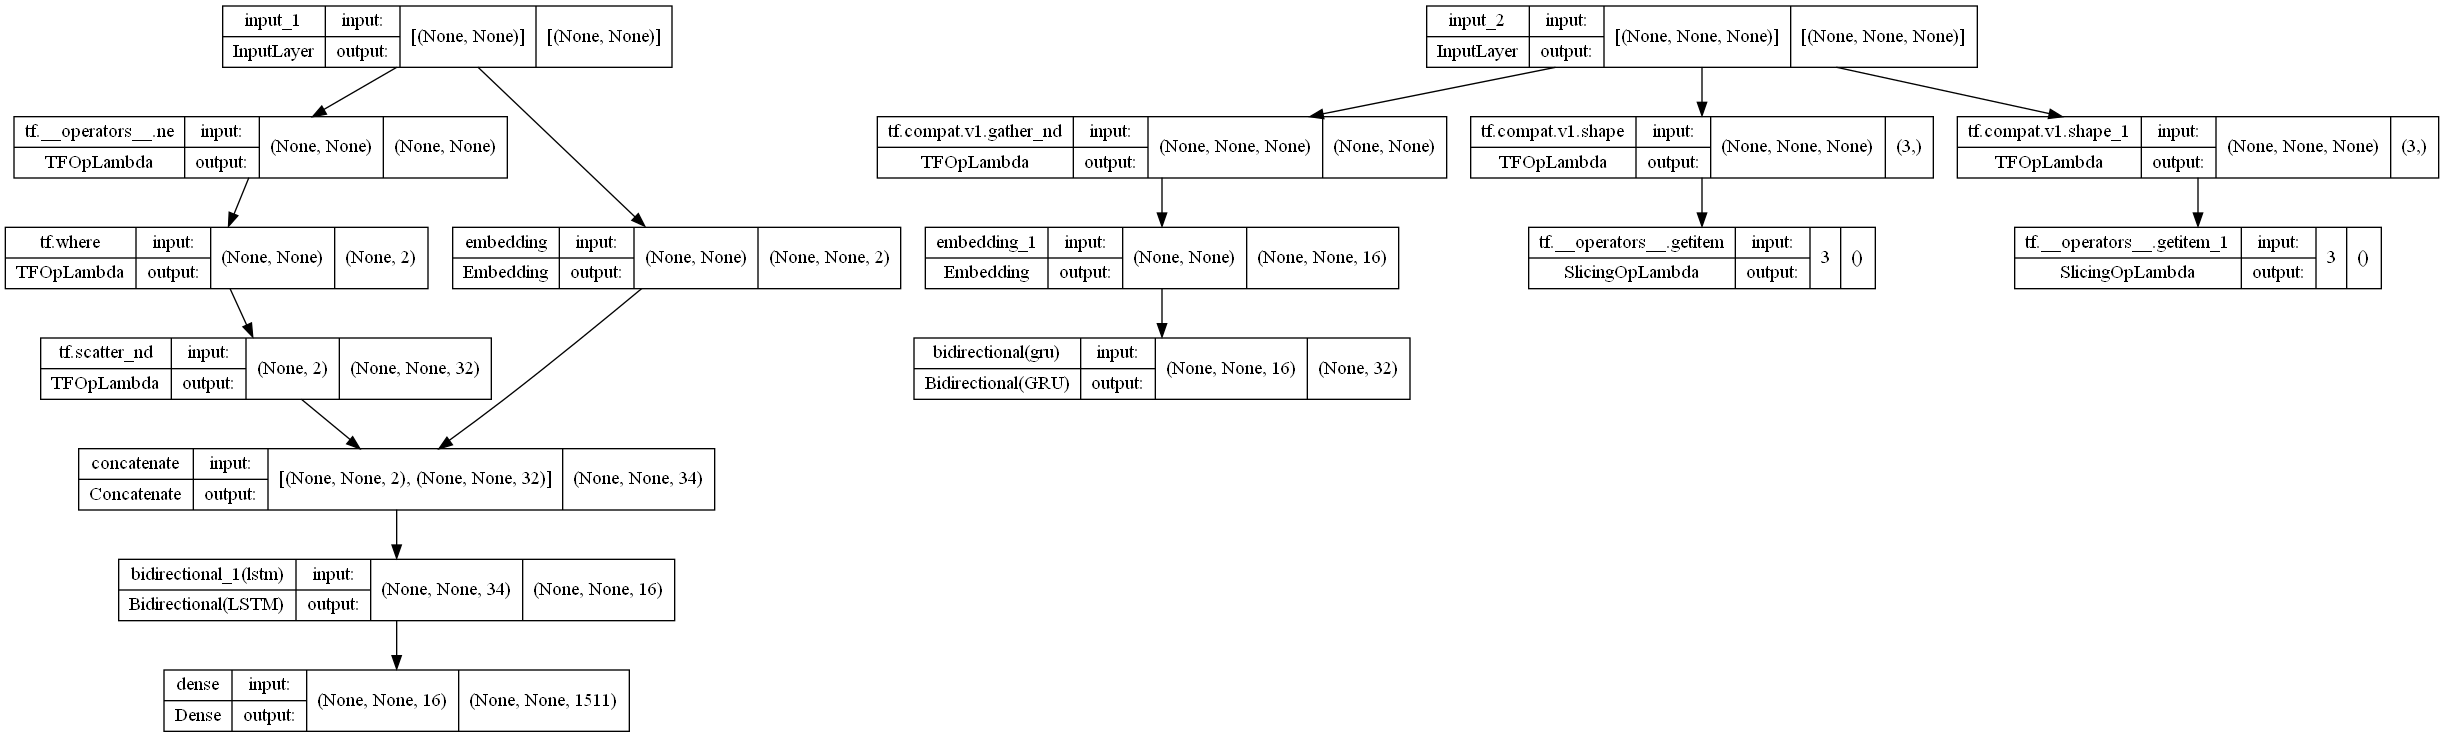

In [23]:
tf.keras.utils.plot_model(network.model, show_shapes=True, show_layer_names=True)

In [24]:
# training
for epoch in range(1):
    network.train_epoch(morpho.train, args)
    metrics = network.evaluate(morpho.dev, "dev", args)
    print(metrics)



{'loss': 1.2512556314468384, 'accuracy': 0.1503496617078781}


In [25]:
# one can change the learning rate manually
network.model.compile(optimizer=tf.optimizers.Adam(learning_rate= 0.0001),
                       loss=tf.losses.SparseCategoricalCrossentropy(),
                       metrics=[tf.metrics.SparseCategoricalAccuracy(name="accuracy")]
)

In [26]:
# then perform more training
for epoch in range(1):
    network.train_epoch(morpho.train, args)
    metrics = network.evaluate(morpho.dev, "dev", args)
    print(metrics)


{'loss': 1.2031900882720947, 'accuracy': 0.16361279785633087}


# Large Movie Review Dataset

<span style="color:red">**TO DO:** Large Movie Review Dataset</span>

- Download the data: https://ai.stanford.edu/%7Eamaas/data/sentiment/, unpack it into the Data folder
- Use RNN to predict the sentiment of the review
- use https://www.tensorflow.org/tutorials/keras/text_classification for inspiration

In [28]:
# remove unlabeled data

from pathlib import Path
remove_dir = Path('./../Data/aclImdb/train') / 'unsup'

shutil.rmtree(remove_dir)

In [31]:
# you can use this code to read the data
# set batch_size and seed
batch_size = 64
seed = 42

train_dir = Path('./../Data/aclImdb/train')

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [32]:
# check a few examples
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])


Review b'An illegal immigrant resists the social support system causing dire consequences for many. Well filmed and acted even though the story is a bit forced, yet the slow pacing really sets off the conclusion. The feeling of being lost in the big city is effectively conveyed. The little person lost in the big society is something to which we can all relate, but I cannot endorse going out of your way to see this movie.'
Label 0
Review b"To get in touch with the beauty of this film pay close attention to the sound track, not only the music, but the way all sounds help to weave the imagery. How beautifully the opening scene leading to the expulsion of Gino establishes the theme of moral ambiguity! Note the way music introduces the characters as we are led inside Giovanna's marriage. Don't expect to find much here of the political life of Italy in 1943. That's not what this is about. On the other hand, if you are susceptible to the music of images and sounds, you will be led into a word

In [33]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])


Label 0 corresponds to neg
Label 1 corresponds to pos
